##Imports

In [2]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np

import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import seaborn as sns
from sklearn.model_selection import train_test_split
import os

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.1


##Parameters

In [3]:
BATCH_SIZE = 32

#There are 11 classes (0 to 9 digits + background class)
n_classes = 11

colors = [tuple(np.random.randint(256, size=3) / 255.0) for i in range(n_classes)]

##Download Dataset

[M2NIST](https://www.kaggle.com/farhanhubble/multimnistm2nist) is **multi digit** [MNIST](http://yann.lecun.com/exdb/mnist/). 
Each image has upto 3 digits from MNIST digits and the corresponding labels file has the segmentstion masks.

The dataset is available on [Kaggle](https://www.kaggle.com).
Link to the dataset: https://www.kaggle.com/farhanhubble/multimnistm2nist

To make it easier for you, we're hosting it on Google Cloud so you can download without kaggle credentials


In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/m2nist.zip \
    -O /tmp/m2nist.zip
import os
import zipfile



local_zip = '/tmp/m2nist.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

--2020-10-27 12:58:37--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/m2nist.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.172.16, 172.217.173.208, 216.58.222.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.172.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17378168 (17M) [application/zip]
Saving to: ‘/tmp/m2nist.zip’

/tmp/m2nist.zip     100%[===================>]  16.57M  18.2MB/s    in 0.9s    

2020-10-27 12:58:38 (18.2 MB/s) - ‘/tmp/m2nist.zip’ saved [17378168/17378168]



##Load and Pre Process Dataset

This dataset can be easily preprocessed since it is available as **Numpy Array Files (.npy)**

1. **tmp/training/combined.npy** has the image files containing the multiple MNIST digits. Each image is of size **64 x 84**.

2. **tmp/training/segmented.npy** has corresponding segmentation masks. Each segmentation mask is also of size **64 x 84**.

This dataset has **5000** samples. You can make appropriate training and validation splits as required for the problem.

In [5]:
#Training, validation and test sizes
train_size = 4000
val_size = 800
test_size = 200

'''
This function maps image and segmentation masks. Images are normalized so that each pixel is in the range [-1, 1]
'''
def read_image_and_annotation(image, annotation):
  image = tf.cast(image, dtype=tf.float32)
  image = tf.reshape(image, (image.shape[0], image.shape[1], 1,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  image = image / 127.5
  image -= 1
  return image, annotation

'''
This function creates training dataset from training splits of images and segmentation masks.
'''
def get_training_dataset(images, annos):
  training_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  training_dataset = training_dataset.map(read_image_and_annotation)

  training_dataset = training_dataset.shuffle(512, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  training_dataset = training_dataset.repeat()
  training_dataset = training_dataset.prefetch(-1)

  return training_dataset


'''
This function creates validation dataset from validation splits of images and segmentation masks.
'''
def get_validation_dataset(images, annos):
  validation_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  validation_dataset = validation_dataset.map(read_image_and_annotation)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  validation_dataset = validation_dataset.repeat()

  return validation_dataset


'''
This function creates test dataset from test splits of images and segmentation masks.
'''
def get_test_dataset(images, annos):
  test_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  test_dataset = test_dataset.map(read_image_and_annotation)
  test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

  return test_dataset

'''
This function loads the images and segments as numpy arrays from npy files and makes splits for training, validation and test datasets.
'''

def load_images_and_segments():
  #Loads images and segmentation masks.
  images = np.load('./training/combined.npy')
  segments = np.load('./training/segmented.npy')

  #Makes training, validation, test splits from loaded images and segmentation masks.
  train_images, val_images, train_annos, val_annos = train_test_split(images, segments, test_size=0.2, shuffle=True)
  val_images, test_images, val_annos, test_annos = train_test_split(val_images, val_annos, test_size=0.2, shuffle=True)

  return (train_images, train_annos), (val_images, val_annos), (test_images, test_annos)


In [6]:
#Load Dataset
train_slices, val_slices, test_slices = load_images_and_segments()

#Create training, validation, test datasets.
training_dataset = get_training_dataset(train_slices[0], train_slices[1])
validation_dataset = get_validation_dataset(val_slices[0], val_slices[1])
test_Dataset = get_test_dataset(test_slices[0], test_slices[1])


In [7]:
#@title Plot Utilities [RUN ME]
def fuse_with_pil(images):
  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]
  
  return new_im

def give_color_to_annotation(annotation):
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1],3) ).astype('float')
  for c in range(n_classes):
    segc = (annotation == c) #np.int32(annotation[:, :, c])
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)
  return seg_img

def show_annotation_and_prediction(image, annotation, prediction, iou_list, dice_score_list):
  new_ann = np.argmax(annotation, axis=2)
  true_img = give_color_to_annotation(new_ann)
  pred_img = give_color_to_annotation(prediction)


  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))
  image = np.uint8(image)
  images = [image, np.uint8(pred_img), np.uint8(true_img)]

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0 and idx < 10]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

  
  display_string_list = ["{}: IOU: {} Dice Score: {}".format(idx, iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n".join(display_string_list)

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(im)
    # if idx == 1:
    #     plt.text(0.5, 4.2, display_string, verticalalignment='center')


  



def show_annotation_and_image(image, annotation):
  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann)
  
  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))

  image = np.uint8(image)
  images = [image, seg_img]
  
  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)


def list_show_annotation(dataset):
  ds = dataset.unbatch()
  #ds = ds.shuffle(buffer_size=100)

  plt.figure(figsize=(20, 15))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  for idx, (image, annotation) in enumerate(ds.take(9)):
    plt.subplot(5, 5, idx + 1)
    plt.yticks([])
    plt.xticks([])
    show_annotation_and_image(image.numpy(), annotation.numpy())

 

###Let's Take a Look at the Dataset

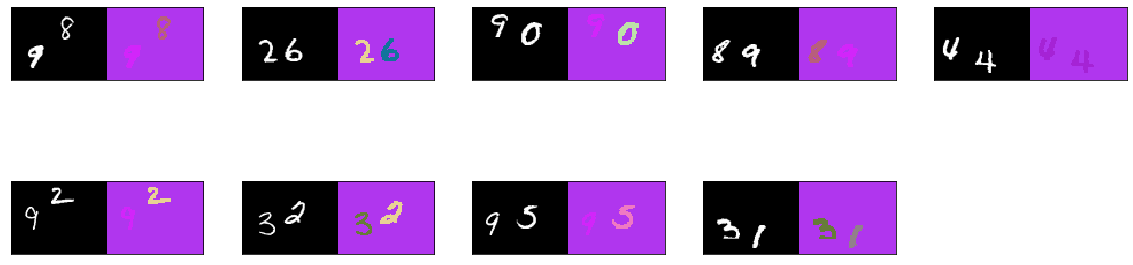

In [8]:
list_show_annotation(training_dataset)

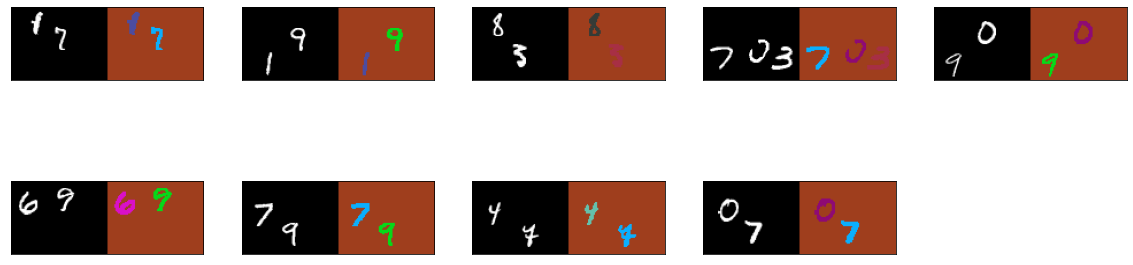

In [8]:
list_show_annotation(validation_dataset)

In [9]:
model = tf.keras.models.load_model("student_model.h5")

In [11]:
test_steps = 200//BATCH_SIZE
results = model.predict(test_Dataset, steps=test_steps)


In [12]:
results = np.argmax(results, axis=3)

###Visualize Predictions

In [13]:
def class_wise_metrics(y_true, y_pred):
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001

  for i in range(n_classes):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score



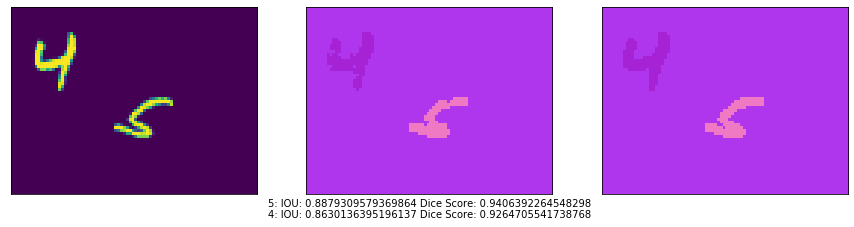

In [14]:
#@title Visualize Output [RUN ME]
integer_slider = 173 #@param {type:"slider", min:0, max:191, step:1}

ds = test_Dataset.unbatch()
ds = ds.batch(200)
images = []

y_true_segments = []
for image, annotation in ds.take(1):
  y_true_segments = annotation
  images = image
  
  
  
iou, dice_score = class_wise_metrics(np.argmax(y_true_segments[integer_slider], axis=2), results[integer_slider])  
show_annotation_and_prediction(image[integer_slider], annotation[integer_slider], results[integer_slider], iou, dice_score)



###Compute IOU Score and Dice Score

In [15]:
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(np.argmax(y_true_segments, axis=3), results)

average_iou = 0.0
for idx, (iou, dice_score) in enumerate(zip(cls_wise_iou[:-1], cls_wise_dice_score[:-1])):
  print("Digit {}: IOU: {} Dice Score: {}".format(idx, iou, dice_score)) 
  average_iou += iou

grade = average_iou * 10 # Divide by 10 to get the average, multiply by 100 to get the grade, so overall mult by 10

print(" Grade is " + str(grade))

PASSING_GRADE = 60
if (grade>PASSING_GRADE):
  print("You passed")
else:
  print("You failed")


Digit 0: IOU: 0.864071305722806 Dice Score: 0.9270796702573099
Digit 1: IOU: 0.8814686300044271 Dice Score: 0.9370006131883826
Digit 2: IOU: 0.8423462076647408 Dice Score: 0.914427705455484
Digit 3: IOU: 0.8429935205540513 Dice Score: 0.9148089899964768
Digit 4: IOU: 0.8446700493321996 Dice Score: 0.9157952660834753
Digit 5: IOU: 0.8223070387018561 Dice Score: 0.9024901086785431
Digit 6: IOU: 0.8552649967063838 Dice Score: 0.9219868840566919
Digit 7: IOU: 0.8643431619940247 Dice Score: 0.9272361222056983
Digit 8: IOU: 0.813582553503324 Dice Score: 0.8972103882800534
Digit 9: IOU: 0.8360345172889192 Dice Score: 0.9106958604715168
 Grade is 84.67081981472734
You passed
